# Ensamble-based Models:
- Combining Models

__Part 1__
   > - Random Forest Classifier
   > - Extra Trees Classifier

In [1]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt, os
import pickle
%matplotlib inline
working_directory = os.getcwd()

In [2]:
# import the encoded covid df
encoded_df = pd.read_csv(working_directory + '/VAERSData/encoded_df.csv')

In [3]:
encoded_df.RECOVD.value_counts()

0    223473
1    212643
Name: RECOVD, dtype: int64

In [4]:
# our target variable
print('NotRecovered(N)=0, Recovered(Y)=1')
encoded_df.RECOVD.value_counts(normalize=True)

NotRecovered(N)=0, Recovered(Y)=1


0    0.512416
1    0.487584
Name: RECOVD, dtype: float64

The Target variable is balanced. otherwise we would have used Stratified_Shuffle_Split to split training and test sets.

## 1- Random Forest and Out-of-bag Error
 
 > - Fit random forest models with a range of trees numbers and evaluate the out-of-bag errors for each model
 > - Plot the resulting oob errors as a function of the number of trees
 
*Note*: since the only thing changing is the number of trees, the `warm_start` flag can be used so the model just add more trees to the exisiting one each time. 
We can use the `set_params` method to update the number of trees in the existing classifier.

In [5]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [6]:
y, X = encoded_df['RECOVD'], encoded_df.drop(columns='RECOVD')

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=42)

In [8]:
from sklearn.ensemble import RandomForestClassifier 

RF = RandomForestClassifier(oob_score =True, random_state=42, warm_start=True, n_jobs=-1)

oob_list = list()

# iterate through all the possibilities of the number of trees
for n_trees in [50, 100, 300, 500, 1000, 2000, 5000, 10000]:
    
    # use this to set the number of trees
    RF.set_params(n_estimators=n_trees)
    
    # fit the model
    RF.fit(X_train, y_train)
    
    # get the oob error
    oob_error = 1- RF.oob_score_
    
    # store it
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))
    

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')    

print('Running Time: 17 min')
rf_oob_df

Running Time: 17 min


,oob
n_trees,
50.0,0.400503
100.0,0.400264
300.0,0.400022
500.0,0.400071
1000.0,0.399563
2000.0,0.399471
5000.0,0.399763
10000.0,0.399802


In [10]:
# Store the df here to save the running time 
pickle.dump(rf_oob_df, open('rf_oob_df.p', 'wb')) 

In [11]:
# Loading the df without the need to run the above code everytime
rf_oob_df = pickle.load(open('rf_oob_df.p', 'rb'))

[Text(0, 0.5, 'out-of-bag error')]

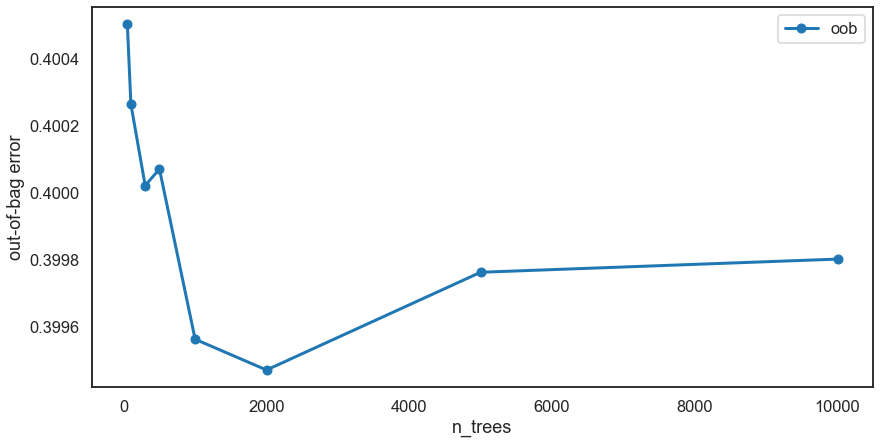

In [13]:
sns.set_context('talk')
sns.set_style('white')

ax = rf_oob_df.plot(legend=True, marker='o', figsize=(14,7), linewidth=3)
ax.set(ylabel='out-of-bag error')

minimal differences in the out-of-bag errors

## 2- Extra Trees Classifier 

 > - Using extra randomized trees. *Note*: `bootstrap` parameter will have to be set to True for this model.
 > - Compare both out-of-bag errors of both classifiers

In [15]:
from sklearn.ensemble import ExtraTreesClassifier 

ET = ExtraTreesClassifier(oob_score =True, random_state=42, warm_start=True, bootstrap=True, n_jobs=-1)

oob_list = list()

# iterate through all the possibilities of the number of trees
for n_trees in [50, 100, 300, 500, 1000, 2000, 5000, 10000]:
    
    # use this to set the number of trees
    ET.set_params(n_estimators=n_trees)
    
    # fit the model
    ET.fit(X_train, y_train)
    
    # get the oob error
    oob_error = 1- ET.oob_score_
    
    # store it
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))
    

et_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')    

et_oob_df

,oob
n_trees,
50.0,0.400621
100.0,0.400402
300.0,0.400094
500.0,0.400169
1000.0,0.399727
2000.0,0.399540
5000.0,0.399799
10000.0,0.399855


In [16]:
pickle.dump(et_oob_df, open('et_oob_df.p', 'wb')) 

In [17]:
et_oob_df = pickle.load(open('et_oob_df.p', 'rb'))

[Text(0, 0.5, 'out-of-bag error')]

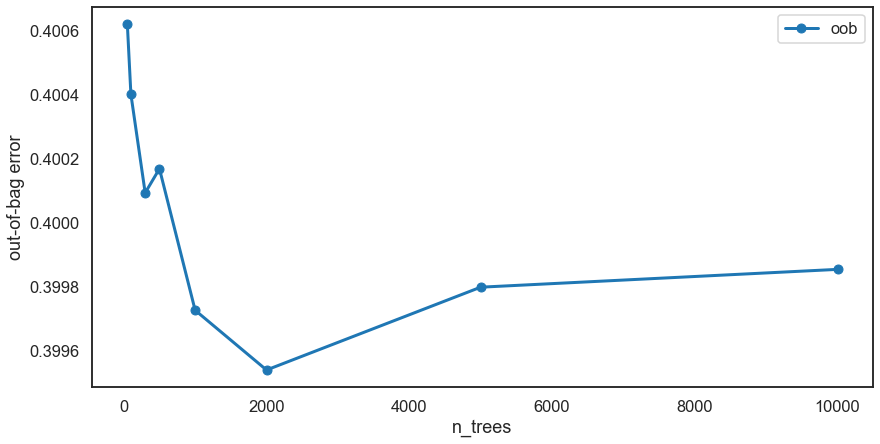

In [18]:
sns.set_context('talk')
sns.set_style('white')

ax = et_oob_df.plot(legend=True, marker='o', figsize=(14,7), linewidth=3)
ax.set(ylabel='out-of-bag error')

Combine both dataframes into single one for easier plotting

In [19]:
oob_df = pd.concat ([rf_oob_df.rename(columns={'oob': 'RandomForest'}), 
                     et_oob_df.rename(columns={'oob': 'ExtraTrees'})], axis=1)

[Text(0, 0.5, 'out-of-bag error')]

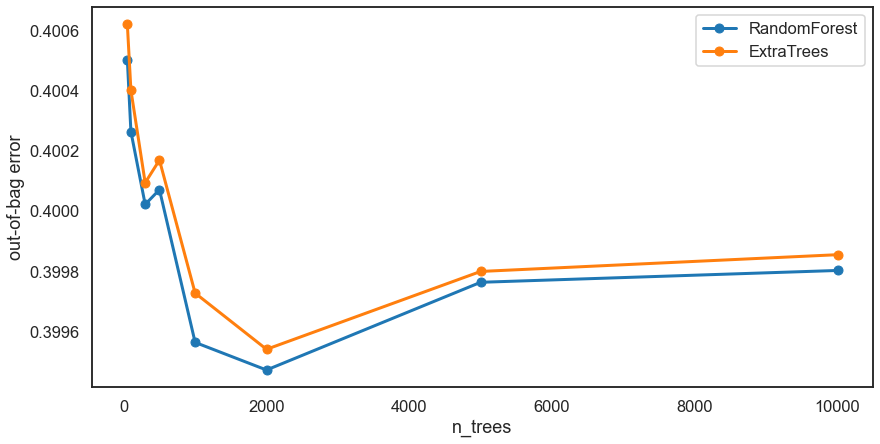

In [20]:
sns.set_context('talk')
sns.set_style('white')

ax = oob_df.plot( marker='o', figsize=(14,7), linewidth=3)
ax.set(ylabel='out-of-bag error')

RandomForest does perform better across each one of the number of estimators with that line of errors consistently below that of ExtraTrees. 

## Confusion Matrix

> - Select one of the models that performs well and calculate error metrics and a confusion matrix on the test data set.
> - Which metric is most important? which could be deceiving?

In [21]:
# Random Forest with 2000 estimators

model = RF.set_params(n_estimators=2000)

y_pred = model.predict(X_test)

# get the probabilities of each of the two categories of our target variable

y_prob = model.predict_proba(X_test)
y_prob

array([[4.47757154e-01, 5.52242846e-01],
       [5.08057116e-01, 4.91942884e-01],
       [4.74919680e-01, 5.25080320e-01],
       ...,
       [5.23953613e-01, 4.76046387e-01],
       [9.99223561e-01, 7.76438666e-04],
       [5.15592692e-01, 4.84407308e-01]])

In [22]:
from sklearn.metrics import classification_report, precision_score, accuracy_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

In [16]:
cr = classification_report(y_test, y_pred)
print(cr)

score_df = pd.DataFrame({'accuracy': accuracy_score(y_test, y_pred),
                        'precision': precision_score(y_test, y_pred),
                        'recall': recall_score(y_test, y_pred),
                        'f1':f1_score(y_test, y_pred),
                        'auc': roc_auc_score(y_test,y_prob[:,1])}, # all rows but only second column 'recovered'
                         index= pd.Index([0]))
display(score_df)

              precision    recall  f1-score   support

           0       0.60      0.66      0.63     67084
           1       0.60      0.53      0.56     63751

    accuracy                           0.60    130835
   macro avg       0.60      0.60      0.60    130835
weighted avg       0.60      0.60      0.60    130835



,accuracy,precision,recall,f1,auc
0,0.598915,0.599675,0.532023,0.563827,0.650556


### Examining Results

> - Visualize confusion matrics
> - Plot ROC-AUC and precision-recall curves.
> - Plot the feature importance

In [18]:
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix

Text(0.5, 13.5, 'Prediction')

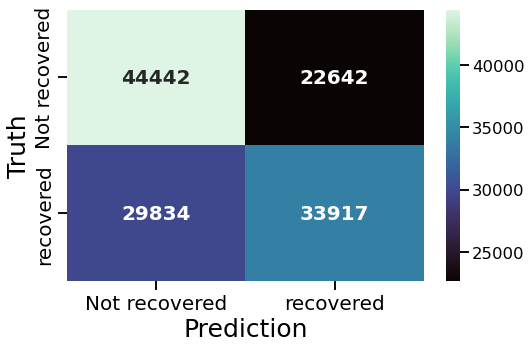

In [24]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
_, ax = plt.subplots(figsize=(8, 5))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='mako', annot_kws={'size':20, 'weight': 'bold'})

labels = ['Not recovered', 'Recovered']
ax.set_xticklabels(labels, fontsize=20);
ax.set_yticklabels(labels, fontsize=20);
ax.set_ylabel('Ground Truth', fontsize=25);
ax.set_xlabel('Prediction', fontsize=25)

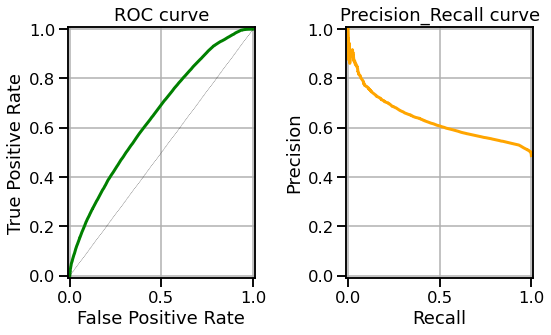

In [28]:
sns.set_context('talk')

fig, axList = plt.subplots(ncols=2)
fig.set_size_inches(8, 5)

# plot the ROC_AUC curve
ax = axList[0]

fpr, tpr, threeholds = roc_curve(y_test, y_prob[:,1])
ax.plot(fpr, tpr, color= 'green', linewidth=3)
# It is customary to draw a diagonal dotted line in Roc plots.
# This is to indicate completely random prediction. Deviation from this 
# dotted line towards the upper left corner signifies the power of the model.

ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
ax.set(xlabel='False Positive Rate',
       ylabel= 'True Positive Rate',
       xlim= [-.01, 1.01], ylim=[-.01, 1.01],
       title= 'ROC curve')

ax.grid(True)

# Plot the precision-recall curve
ax = axList[1]

precision, recall, _ = precision_recall_curve(y_test, y_prob[:,1])
ax.plot(recall, precision, color='orange', linewidth=3)
ax.set(xlabel= 'Recall', ylabel='Precision', 
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title= 'Precision_Recall curve')
ax.grid(True)
plt.tight_layout()

[Text(0, 0.5, 'Feature')]

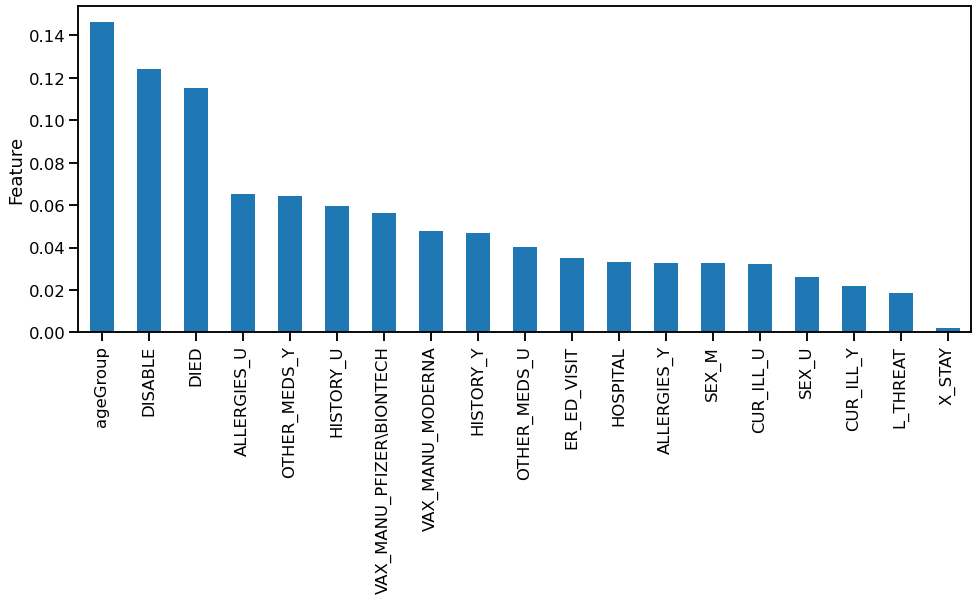

In [32]:
feature_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

ax = feature_imp.plot(kind='bar', figsize=(16, 6))
ax.set(ylabel='Relative Importance')
ax.set(ylabel='Feature')